In [190]:
import matplotlib
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from collections import defaultdict
from typing import Sequence
 
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

from qiskit_aer import AerSimulator

## Part 1. Small-Scale QAOA

### Step 1: Map classical inputs to a quantum problem

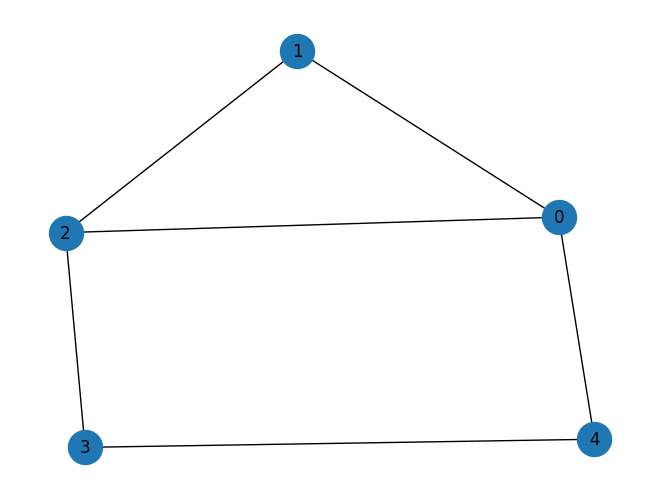

In [191]:
n = 5
 
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 4, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [192]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.
 
    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("ZZ", [edge[0], edge[1]], weight))
    return pauli_list
 
 
max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, n)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


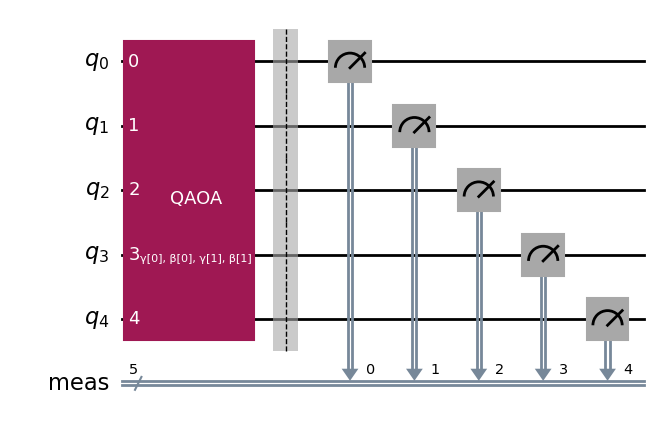

In [193]:
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()
 
circuit.draw("mpl")

In [194]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

### Step 2: Optimise problem for quantum hardware execution

AerSimulator('aer_simulator')


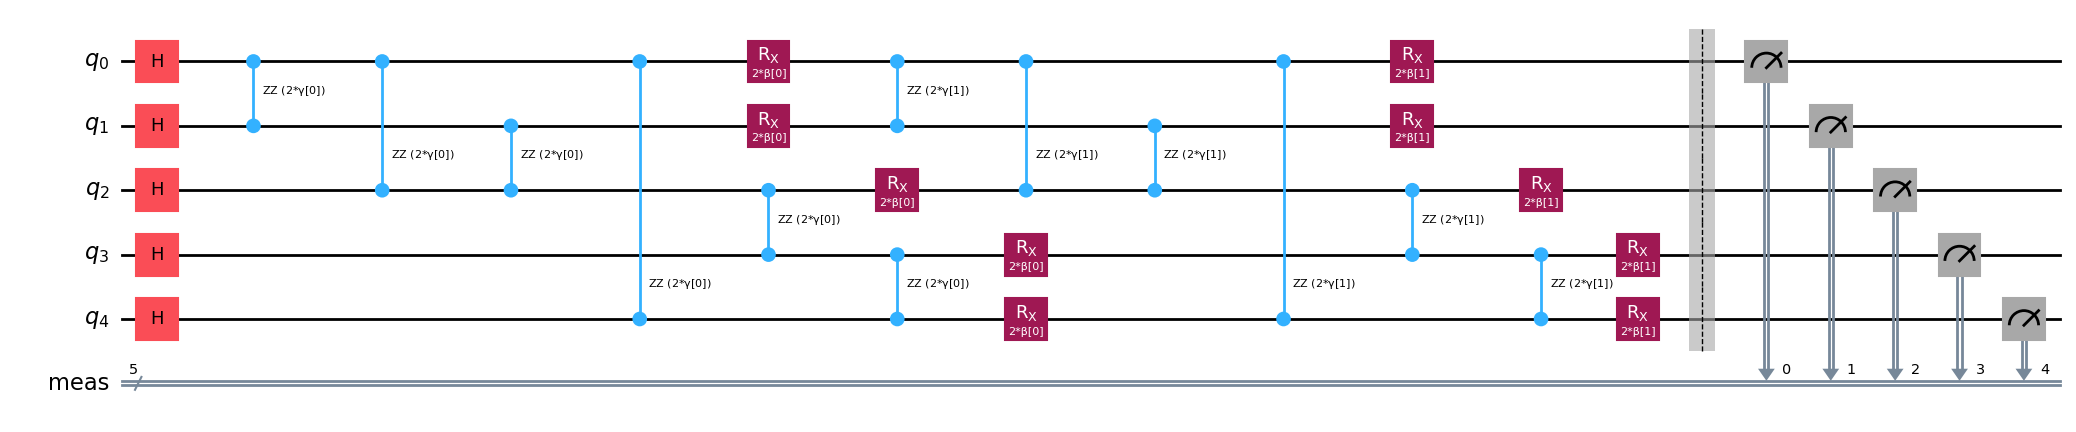

In [195]:
####### IF wanting to use real backend #######
# service = QiskitRuntimeService()
# backend = service.least_busy(
#    operational=True, simulator=False, min_num_qubits=127
# )

backend = AerSimulator()  # local simulator
print(backend)
 
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
 
candidate_circuit = pm.run(circuit)
candidate_circuit.draw("mpl", fold=False, idle_wires=False)

### Step 3: Execute using Qiskit primitives

In [196]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta, initial_beta, initial_gamma, initial_gamma]

In [197]:
objective_func_vals = []  # Global variable

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
 
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
 
    results = job.result()[0]
    cost = results.data.evs
 
    objective_func_vals.append(cost)
 
    return cost

In [198]:
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000
 
    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"
 
    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -2.02997002997003
       x: [ 3.036e+00  1.168e+00  4.300e+00  2.246e+00]
    nfev: 31
   maxcv: 0.0


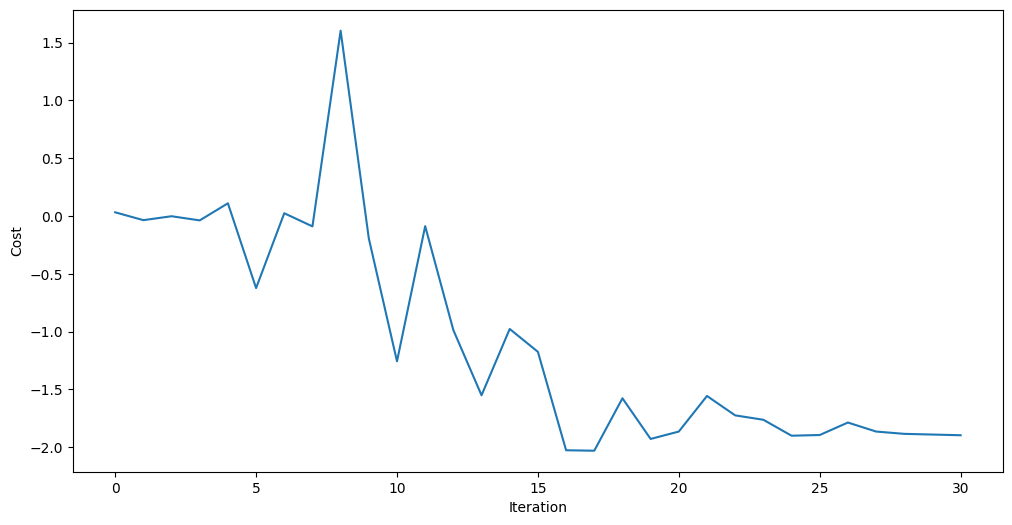

In [199]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

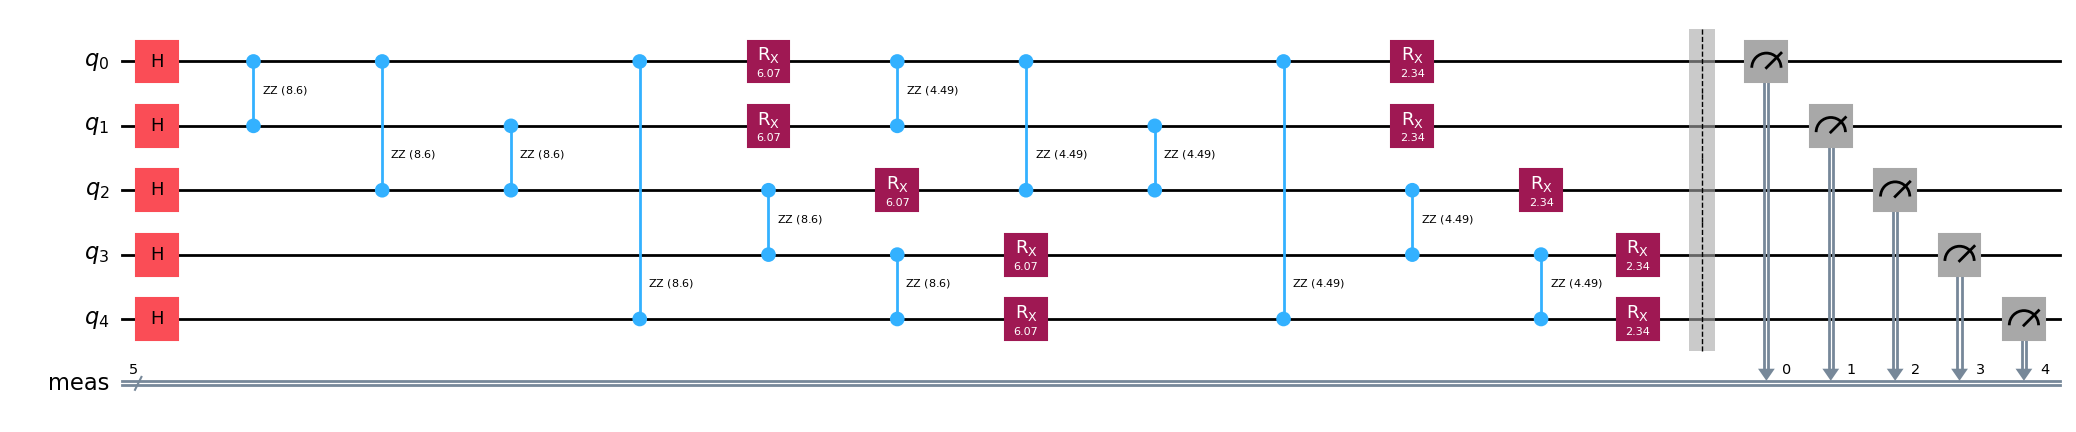

In [200]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw("mpl", fold=False, idle_wires=False)

In [201]:
# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000
 
# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"
 
pub = (optimized_circuit,)
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val / shots for key, val in counts_int.items()}
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
print(final_distribution_int)

{14: 0.0407, 24: 0.0101, 21: 0.0386, 20: 0.0936, 22: 0.098, 10: 0.0338, 5: 0.0581, 26: 0.0574, 4: 0.0236, 25: 0.0141, 3: 0.0144, 13: 0.0368, 9: 0.0879, 6: 0.0137, 11: 0.0959, 17: 0.0378, 18: 0.0411, 19: 0.0388, 8: 0.0039, 12: 0.0394, 28: 0.0147, 0: 0.0089, 30: 0.0208, 27: 0.0203, 29: 0.002, 23: 0.0038, 1: 0.0208, 31: 0.0076, 7: 0.0115, 2: 0.0027, 15: 0.005, 16: 0.0042}


### Step 4: Post-process and return result in desired classical format


In [202]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]
 
 
keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()
 
print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 1, 0, 1]


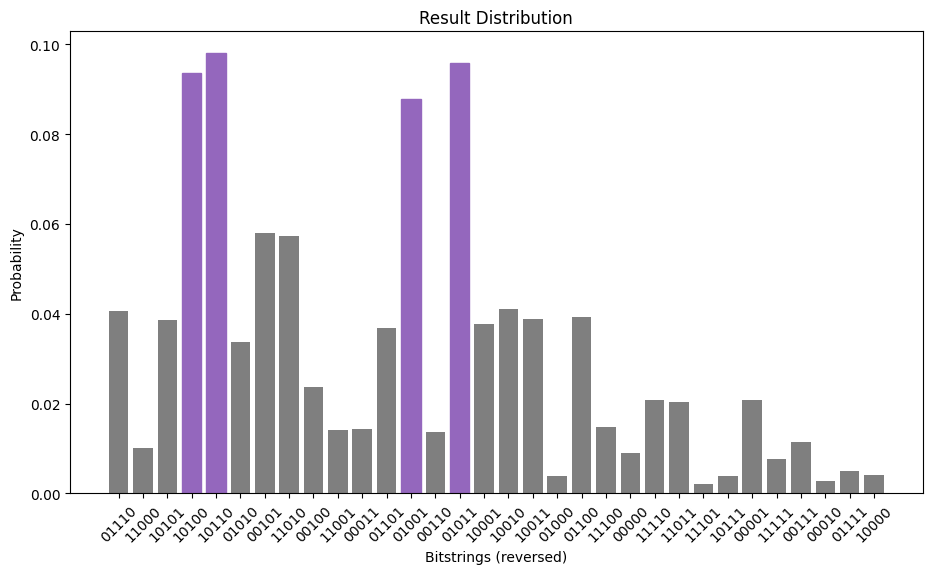

In [203]:
matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p[0])].set_color("tab:purple")
plt.show()

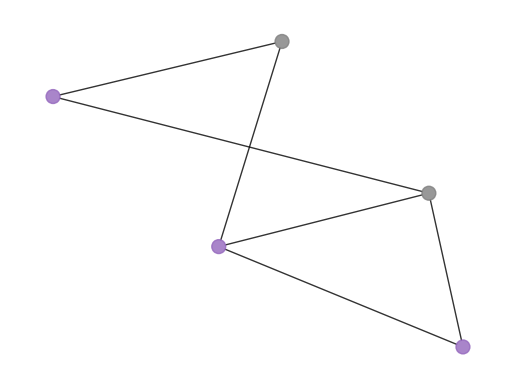

In [204]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, _default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(
        G, node_color=colors, node_size=100, alpha=0.8, pos=pos
    )
 
 
plot_result(graph, most_likely_bitstring)

In [205]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(
        list(graph.nodes())
    ), "The length of x must coincide with the number of nodes in the graph."
    return sum(
        x[u] * (1 - x[v]) + x[v] * (1 - x[u])
        for u, v in list(graph.edge_list())
    )
 
 
cut_value = evaluate_sample(most_likely_bitstring, graph)
print("The value of the cut is:", cut_value)

The value of the cut is: 5
